In [1]:
# 先不取平均 看一看能否说明问题
import numpy as np
import sys
import os
import matplotlib.pyplot as plt

# 设置全局字体为Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'

In [54]:
# 读取xyz数据
root = r'C:\Users\81004\Desktop\las_paper\ana_data\1800'
file_name =  "cry_2000p_origin.lmp"
file_path = os.path.join(root,file_name)

start_frame = 0
end_frame = 1000
step_frame = 2
###########

# 要分析的元素
ana_element = ['Si','O','Al']
# lmp对应的值
dic_charge = {2.4:'Si', -1.2:'O', 1.8:'Al', 0.6:'Li'}
# 画出分布的元素
draw_element = ['O']
set_cutoff = 4.0

In [57]:
# 先按照要求读取所有的lmp数据
# 每一个原子的信息
class Atom:
    def __init__(self, id0, type0, q, x, y, z, vx, vy, vz, fx, fy, fz, c_ke_atom, c_pe_atom, v_e_total):
        self.id = int(id0)
        self.type = str(type0)
        self.x = x
        self.y = y
        self.z = z
        self.q = q
        self.vx = vx
        self.vy = vy
        self.vz = vz
        self.fx = fx
        self.fy = fy
        self.fz = fz
        self.c_ke_atom = c_ke_atom
        self.c_pe_atom = c_pe_atom
        self.v_e_total = v_e_total
    def print_info(self):
        print(f'id:{int(self.id)}, type:{self.type}, x:{self.x}, y:{self.y}, z:{self.z}, q:{self.q}')
        print(f'vx:{self.vx}, vy:{self.vy}, vz:{self.vz}, fx:{self.fx}, fy:{self.fy}, fz:{self.fz}')
        print(f'E_total:{self.v_e_total}, E_kinetic:{self.c_ke_atom}, E_potential:{self.c_pe_atom}')

In [59]:
class Atom_sys(Atom):
    def __init__(self, atom_instance, q4=None, q6=None, dis=None,):
        # 继承 Atom 实例的所有属性
        super().__init__(atom_instance.id, atom_instance.type, atom_instance.q,
                         atom_instance.x, atom_instance.y, atom_instance.z,
                         atom_instance.vx, atom_instance.vy, atom_instance.vz,
                         atom_instance.fx, atom_instance.fy, atom_instance.fz,
                         atom_instance.c_ke_atom, atom_instance.c_pe_atom, atom_instance.v_e_total)
        # 添加新的属性
        self.q4 = q4 
        self.q6 = q6 
        self.dis = dis 

    def print_info(self):
        super().print_info()
        print(f'q4: {self.q4}, q6: {self.q6}, dis: {self.dis}')

In [61]:
# 示例
atom = Atom(1, 2, 0.1, 1.0, 2.0, 3.0, 0.5, 0.6, 0.7, -0.1, -0.2, -0.3, 5.0, 10.0, 15.0)

In [63]:
atom_sys = Atom_sys(atom, q4=0.85, dis=1.5)

In [65]:
atom_sys.print_info()

id:1, type:2, x:1.0, y:2.0, z:3.0, q:0.1
vx:0.5, vy:0.6, vz:0.7, fx:-0.1, fy:-0.2, fz:-0.3
E_total:15.0, E_kinetic:5.0, E_potential:10.0
q4: 0.85, q6: None, dis: 1.5


In [68]:
def read_lmp(file_path):
    # 所有信息储存的总列表
    list_all_frames = []
    x_min,x_max,y_min,y_max,z_min,z_max = None,None,None, None,None,None
    box_size = [None, None, None]
    num_atom = None
    len_per_frame = None
    # 第一次打开,是看一下基本数据：
    with open(file_path,'r') as f_open:
        # 前三行都不要
        for i in range(3): 
            f_open.readline()
        # 第四行是Number
        num_atom = int(f_open.readline())
        # 定义一页的行数
        len_per_frame = num_atom + 9  
        # 第五行不要
        f_open.readline()
        # 存储range范围
        temp_range_list = []
        for i in range(3): 
            temp_min,temp_max = f_open.readline().split()
            temp_range_list.append(temp_min)
            temp_range_list.append(temp_max)
        # 将字符串转换为浮点数并直接赋值给变量
        x_min, x_max, y_min, y_max, z_min, z_max = [float(i) for i in temp_range_list]
    print(f'Num of atom: {num_atom}')
    print(f'X range: {x_min}  {x_max}')
    print(f'Y range: {y_min}  {y_max}')
    print(f'Z range: {z_min}  {z_max}\n')
    
    # 开始读取文件
    f_open = open(file_path,'r')
    # 记录当前行数
    count_row = 0
    for i_frame in range(start_frame, end_frame, step_frame):
        if i_frame%50==0:
            print(f'Now is reading frame {i_frame}')
        list_frame = []
        # 先判断下是不是我要的这页
        now_frame_count = len_per_frame*i_frame
        # 如果不是同一页，则跳过这一页,再继续空读
        while count_row!=now_frame_count:
            # print(f'Now:{now_frame_count}  count:{count_row}')
            count_row+=len_per_frame
            for i in range(len_per_frame):
                f_open.readline()
        # 如果是同一页，那么就开始读取数据
        else:
            # print(f'Now:{now_frame_count}  count:{count_row}')
            # 首先就是跳过表头的9行
            # for i in range(9):
            #     f_open.readline()
            # 读取表头九行的数据
            f_open.readline()
            time_step = int(f_open.readline())
            f_open.readline()
            atom_num = float(f_open.readline())
            f_open.readline()
            x_low,x_high = f_open.readline().split()
            y_low,y_high = f_open.readline().split()
            z_low,z_high = f_open.readline().split()
            f_open.readline()
            x_low,x_high,y_low,y_high,z_low,z_high = float(x_low),float(x_high),float(y_low),float(y_high),float(z_low),float(z_high)
            dic_system = {'timestep':time_step, 
                         'num_atoms':atom_num,
                          'x_low':x_low,'x_high':x_high,
                          'y_low':y_low,'y_high':y_high,
                          'z_low':z_low,'z_high':z_high,
                         }
            # 再读取其余的数据
            for j_row in range(num_atom):
                temp_data = f_open.readline().split()
                id0, type0, q, x, y, z, vx, vy, vz, fx, fy, fz, c_ke_atom, c_pe_atom, v_e_total = [float(i) for i in temp_data]
                #print(id0, type0, q, x, y, z)
                # 类型转换回 str
                type0 = dic_charge[q]
                temp_atom = Atom(id0, type0, q, x, y, z, vx, vy, vz, fx, fy, fz, c_ke_atom, c_pe_atom, v_e_total)
                list_frame.append(temp_atom)
            # 这一页读取完了,首先是对原子的id排序
            list_frame = sorted(list_frame, key = lambda Atom:Atom.id)
            # 再存入信息帧中
            frame_data = {
                "atom_data":list_frame,
                'system_info':dic_system
            }
            list_all_frames.append(frame_data)
            count_row+=len_per_frame
         
    # 关闭文件
    print('文件读取完毕！')
    f_open.close()
    return list_all_frames
def read_xyz_frames(file_path):
    frames = []
    current_frame = None

    with open(file_path, 'r') as file:
        lines = file.readlines()
        line_index = 0

        while line_index < len(lines):
            line = lines[line_index].strip()

            if line.isdigit():
                # 读取原子数
                if current_frame:
                    frames.append(current_frame)
                num_atoms = int(line)
                current_frame = {"num_atoms": num_atoms, "atoms": []}
                line_index += 2  # 跳过标题行 "Atoms"
            else:
                # 读取原子坐标
                if current_frame:
                    atom_data = line.split()
                    if len(atom_data) == 4:
                        element, x, y, z = atom_data
                        current_frame["atoms"].append({
                            "element": element,
                            "x": float(x),
                            "y": float(y),
                            "z": float(z)
                        })
                line_index += 1

        if current_frame:
            frames.append(current_frame)
    print('文件读取完毕！')
    return frames

In [70]:
file_type = file_path.split('\\')[-1].split('.')[-1]
frames = []
if file_type=='lmp':
    print('输入文件为lmp格式！')
    frames = read_lmp(file_path)   
elif file_type=='xyz':
    frames = read_xyz_frames(file_path)
    # 找出最大的x、y和z值
    max_x = max([max(frame["atoms"], key=lambda atom: atom["x"])["x"] for frame in frames])
    max_y = max([max(frame["atoms"], key=lambda atom: atom["y"])["y"] for frame in frames])
    max_z = max([max(frame["atoms"], key=lambda atom: atom["z"])["z"] for frame in frames])
    print("Maximum X value:", max_x)
    print("Maximum Y value:", max_y)
    print("Maximum Z value:", max_z)
else:
    print('输入文件有误！')

输入文件为lmp格式！
Num of atom: 6006
X range: -0.05780681678287891  126.29042044531153
Y range: -0.02520293888203895  55.06080293887457
Z range: -0.005242346471363568  11.452942346473058

Now is reading frame 0
Now is reading frame 50
Now is reading frame 100
Now is reading frame 150
Now is reading frame 200
Now is reading frame 250
Now is reading frame 300
Now is reading frame 350
Now is reading frame 400
Now is reading frame 450
Now is reading frame 500
Now is reading frame 550
Now is reading frame 600
Now is reading frame 650
Now is reading frame 700
Now is reading frame 750
Now is reading frame 800
Now is reading frame 850
Now is reading frame 900
Now is reading frame 950
文件读取完毕！


In [71]:
All_Atom = []
for i_frame in frames:
    temp_atom = i_frame['atom_data']
    All_Atom.append(temp_atom)

# 输出lmp 排好序的

In [76]:
frames[0]['atom_data'][2].fy

0.669695

In [78]:
frames[0]['system_info']

{'timestep': 1000000,
 'num_atoms': 6006.0,
 'x_low': -0.05780681678287891,
 'x_high': 126.29042044531153,
 'y_low': -0.02520293888203895,
 'y_high': 55.06080293887457,
 'z_low': -0.005242346471363568,
 'z_high': 11.452942346473058}

# 使用pyscal计算Q4-Q6

In [81]:
from pyscal3 import System
from pyscal3 import Atoms

In [82]:
def cal_bop(cal_list,ana_frame):
    frames = cal_list
    temp_system = frames[ana_frame]['system_info']
    temp_frame = frames[ana_frame]['atom_data']
    len_x,len_y,len_z = temp_system['x_high'],temp_system['y_high'],temp_system['z_high']
    sys = System()
    sys.box = [[len_x,0,0],[0,len_y,0],[0,0,len_z]]
    # sys.box = [[117.413928, 0, 0], [0, 58.746064, 0], [0, 0, 11.158]]
    # 将list转为字典 取出我们要分析的元素 
    ana_atom_list = []
    atom_xyz = []
    for i_atom in temp_frame:
        if i_atom.type in ana_element: 
            atom_xyz.append([i_atom.x,i_atom.y,i_atom.z])
            ana_atom_list.append(i_atom)
    print(np.array(atom_xyz).shape)
    # 转换元素格式
    adict = {"positions": np.array(atom_xyz, dtype=object)}
    atoms = Atoms(adict)
    # print(atoms.species)
    # print(atoms.positions)
    # 实例化
    sys.atoms = atoms
    # 这是pyscal3的Adaptive cutoff methods
    sys.find.neighbors(method='cutoff', cutoff='adaptive', padding=1.5)
    coordination = [len(sys.atoms.neighbors.index[x]) for x in range(sys.natoms)]
    #################
    nos, counts = np.unique(coordination, return_counts=True)
    plt.bar(nos, counts, color="#AD1457")
    plt.ylabel("density")
    plt.xlabel("coordination number")
    plt.title("Cutoff adaptive method")
    # 计算q4和q6 然后采用均值的方法
    # q4_q6_list = sys.calculate.steinhardt_parameter([4,6], averaged=True)
    q4_q6_list = sys.calculate.steinhardt_parameter([4,6], averaged=True)
    print(f'Mean_q4:{sum(q4_q6_list[0])/len(q4_q6_list[0])}')
    return ana_atom_list, q4_q6_list,[len_x,len_y,len_z]

# 绘制BOP的帧数

In [157]:
ana_frame_num = 200

(5148, 3)
Mean_q4:0.16135136207855033
[126.26585647974451, 55.05009340395584, 11.450714705770661]


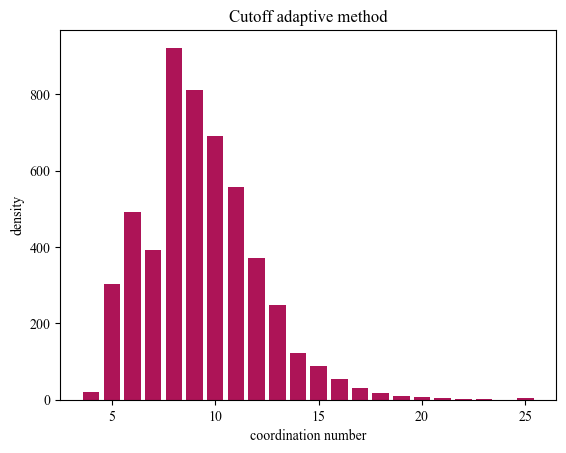

In [159]:
ana_frame_list = frames[ana_frame_num]['atom_data']
origin_ana_atom_list, origin_q4_q6_list,box_len = cal_bop(frames,ana_frame_num)
print(box_len)
####
# 给分析的这些原子进行 赋值
all_atomsys_list = []
for i_atom in ana_frame_list:
    i_id = i_atom.id
    q4,q6 = None,None
    for j_atom,j_q4,j_q6 in zip(origin_ana_atom_list,origin_q4_q6_list[0],origin_q4_q6_list[0]):
        j_id = j_atom.id 
        if j_id==i_id:
            q4 = j_q4
            q6 = j_q6
    temp_atom = Atom_sys(i_atom,q4=q4,q6=q6)
    all_atomsys_list.append(temp_atom)
ana_frame_list = all_atomsys_list

In [160]:
all_atomsys_list[0].print_info()

id:1, type:O, x:15.9331, y:19.1896, z:5.04726, q:-1.2
vx:-16.6241, vy:2.97762, vz:9.53935, fx:1.54519, fy:-0.875056, fz:-0.210166
E_total:-9.60728, E_kinetic:0.311932, E_potential:-9.91922
q4: 0.10309396385357096, q6: 0.10309396385357096, dis: None


In [161]:
None_Li_list = [i for i in all_atomsys_list if i.type!='Li']
print(len(None_Li_list))

5148


# bop数据处理

In [163]:
draw_element = ['Si','Al','O'] 
draw_ele_list = [i for i in all_atomsys_list if i.type in draw_element ]

# 可视化分布

In [165]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
    
def draw_q4(data_temp,critical_q4,label_list,title_name):
    # 从 data_list 中提取 x、y、q4 和 q6 数据
    #########
    x_data = [item.x for item in data_temp]
    y_data = [item.y for item in data_temp]
    q4_data = [item.q4 for item in data_temp]
    q6_data = [item.q6 for item in data_temp]
    # 创建二维分布图
    plt.figure(figsize=(10, 6) ,dpi=80)
    mean_q4 = sum(q4_data)/len(q4_data)
    num_max_q4 = len([i for i in q4_data if i>critical_q4])
    print('Mean q4:' + str(round(mean_q4,4))+' Percentage of Q4 > 0.18:'+ str(round(num_max_q4/len(q4_data)*100,2))+'%')
    
    ###########################################
    # 定义viridis色谱的底端绿色渐变
    
    viridis_cmap = plt.get_cmap('viridis')
    
    # 生成顶端橙黄色的渐变，使用非常短的橙色段
    orange_yellow = ['#ffea00', '#ff7f0e']  # 橙色到黄色的 HEX 色码，顺序调整为黄色到橙色
    orange_yellow_cmap = LinearSegmentedColormap.from_list('orange_yellow', orange_yellow, N=8)
    
    # 合并两个色谱，创建自定义色谱
    colors = np.vstack((viridis_cmap(np.linspace(0, 1, 128)),
                        orange_yellow_cmap(np.linspace(0, 1, 8))))  # 使用非常短的橙色段
    custom_cmap = ListedColormap(colors)
    ###########################################################
    name_x = file_path.split('\\')[-1]
    # 绘制 q4 在 x-y 平面上的二维分布图
    title_name = title_name
    plt.title(title_name , fontsize=15, fontweight='bold') 
    
    ################
    plt.scatter(x_data, y_data, s=15, c=q4_data, cmap=custom_cmap, marker='o',vmin=0.05, vmax=critical_q4)
    plt.colorbar()
    plt.scatter(label_list[0],label_list[1],color='blue')
    # plt.title('O' , fontsize=15, fontweight='bold')  
    plt.xlabel('X-axis ', fontsize=15, fontweight='bold')  # 设置 x 轴标签字体大小和加粗
    plt.ylabel('Y-axis', fontsize=15, fontweight='bold')  # 设置 y 轴标签字体大小和加粗
    
    # 设置 x 轴刻度值的字体大小、颜色和加粗
    plt.xticks(range(0, int(max(x_data)) + 1, 10), fontsize=12, fontweight='bold')
    # 设置 y 轴刻度值的字体大小、颜色和加粗
    plt.yticks(fontsize=12, fontweight='bold')
    # plt.legend()
    plt.show()

cry atom: 1893
Mean q4:0.1614 Percentage of Q4 > 0.18:36.77%


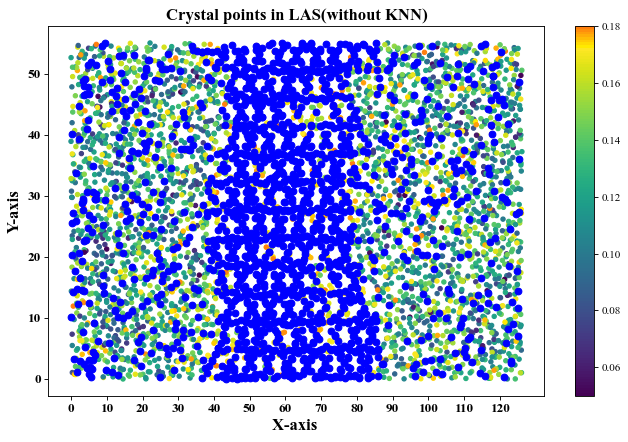

In [166]:
critical_q4 = 0.18
cry_point = []
for i_item in draw_ele_list:
    i_atom,i_q4,i_q6 = i_item, i_item.q4, i_item.q6
    if i_q4>critical_q4:
        cry_point.append(i_atom)
print(f'cry atom: {len(cry_point)}')
cry_xyz = [[i.x for i in cry_point],[i.y for i in cry_point]]
draw_q4(draw_ele_list, critical_q4, cry_xyz,'Crystal points in LAS(without KNN)')

# 数据清洗

In [168]:
def cal_ppp_dis_object(boxsize,point1,point2):
    i_1 = np.array([point1.x,point1.y,point1.z])
    j_1 = np.array([point2.x,point2.y,point2.z])
    boxsize = np.array(boxsize)
    # 计算
    delta = i_1-j_1
    delta = delta - np.round(delta / boxsize) * boxsize
    distance = np.linalg.norm(delta)
    return distance

In [169]:
# 遍历每一个原子 根据
critical_dis = 5.0
critical_q4 = 0.18
critical_neibor_cry = 15
boxsize = box_len
# 
def filter_bop(temp_list):
    # 第一次是去除性地筛选
    filter_list = []
    for i_atom in temp_list:
        i_q4 = i_atom.q4
        # 如果原子不是q4>0.18
        if i_q4<critical_q4:
            filter_list.append(i_atom)
            continue
        #  如果大于0.18
        else:   
            count_cry = 0
            for j_atom in temp_list:
                j_q4 = j_atom.q4
                if cal_ppp_dis_object(boxsize,i_atom,j_atom)<critical_dis and j_q4>critical_q4 :
                    count_cry+=1
            if count_cry<critical_neibor_cry:
                i_atom.q4 = np.random.uniform(0.12, 0.17)
            #elif count_cry>=critical_neibor_cry and i_q4<critical_q4:
                #i_q4 = critical_q4+0.01
            filter_list.append(i_atom)
    # 第二次是确定性地添加
    filter_list_1 = []
    for i_atom in filter_list:
        i_q4 = i_atom.q4
        # 如果原子不是q4>0.18
        if i_q4>critical_q4:
            filter_list_1.append(i_atom)
            continue
        #  如果大于0.18
        else:   
            count_cry = 0
            for j_atom in filter_list:
                j_q4 = j_atom.q4
                if cal_ppp_dis_object(boxsize,i_atom,j_atom)<critical_dis and j_q4>critical_q4 :
                    count_cry+=1
            if count_cry>critical_neibor_cry:
                i_atom.q4 = np.random.uniform(0.181, 0.21)
            #elif count_cry>=critical_neibor_cry and i_q4<critical_q4:
                #i_q4 = critical_q4+0.01
            filter_list_1.append(i_atom)
    return  filter_list_1

Mean q4:0.1573 Percentage of Q4 > 0.18:32.81%


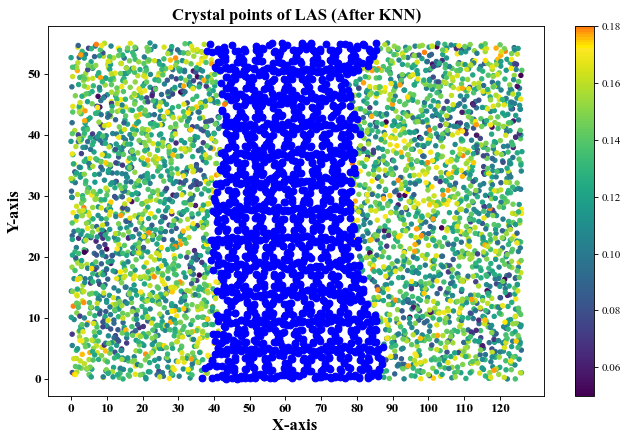

In [170]:
draw_knn_q4_list = filter_bop(draw_ele_list)
cry_point = [[i.x for i in draw_knn_q4_list if i.q4>critical_q4],[i.y for i in draw_knn_q4_list if i.q4>critical_q4]]
draw_q4(draw_knn_q4_list,0.18,cry_point,'Crystal points of LAS (After KNN)')

# 然后计算出不同距离dis的原子

In [180]:
cry_atom = [i for i in draw_knn_q4_list if i.q4>critical_q4]
draw_knn_q4q6dis_list = []
for i in draw_knn_q4_list:
    i.dis = 100
    draw_knn_q4q6dis_list.append(i)

# 计算距离 
for i_atom in draw_knn_q4q6dis_list:
    for j_atom in cry_atom:
        # 算距离 
        dis = cal_ppp_dis_object(boxsize,i_atom,j_atom)
        if dis<i_atom.dis:
            i_atom.dis = dis

In [181]:
draw_knn_q4q6dis_list[-1].print_info()

id:6006, type:Si, x:69.4959, y:0.262982, z:10.3174, q:2.4
vx:1.2156, vy:-0.827294, vz:-1.10613, fx:1.12219, fy:-5.34588, fz:-5.7595
E_total:-35.0582, E_kinetic:0.00492753, E_potential:-35.0632
q4: 0.21821824226734962, q6: 0.21821824226734962, dis: 0.0


In [182]:
# 记录下Atom和frame,然后在下一个时间刻度内进行筛选

# 之后就是按照元素分析性质了

In [198]:
# 选出固定范围内的原子
dis_range = [0.1,20]
# 选取的中心 晶体中的原子
cry_q4q6dis_ele = ['Al','Si','O']
# 选取的是 界面处的原子
inter_q4q6dis_ele = ['O']

Mean q4:0.1573 Percentage of Q4 > 0.18:32.81%


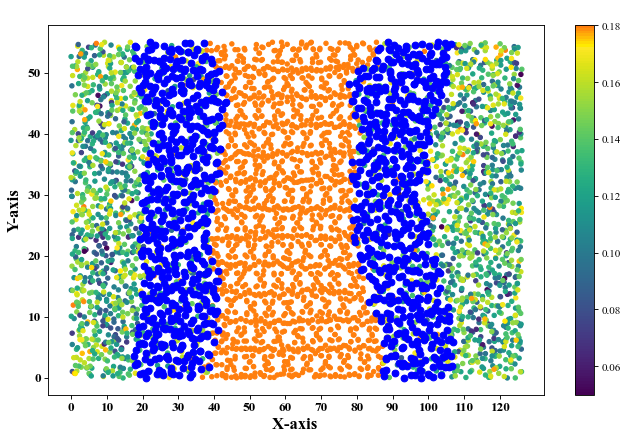

In [200]:
cry_q4q6dis_lis =[i for i in draw_knn_q4q6dis_list if i.dis<1e-4 and i.type in inter_q4q6dis_ele]
inter_q4q6dis_list=[i for i in draw_knn_q4q6dis_list if dis_range[0]<i.dis<dis_range[1] and i.type in inter_q4q6dis_ele]
neibor_atom_list = inter_q4q6dis_list
dis_xy = [[i.x for i in neibor_atom_list],[i.y for i in neibor_atom_list]]
# 这是所有原子 label_atoms_list
draw_q4(draw_knn_q4q6dis_list, 0.18, dis_xy, ' ')

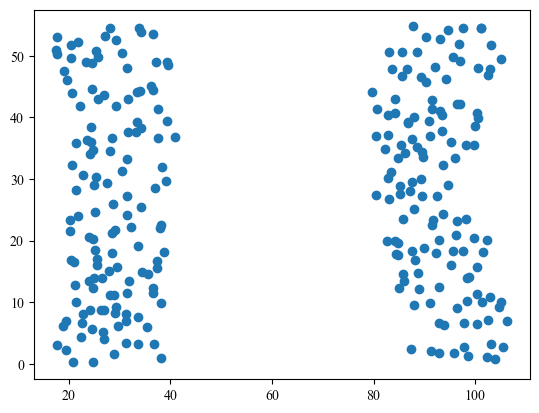

In [185]:
plt.scatter(dis_xy[0],dis_xy[1])

#  分析当下的帧数信息

In [ ]:
neibor_atom_list[0].print_info()
print(' ')
neibor_atom_list[-1].print_info()

In [ ]:
# 记下所有原子的id 然后找过一段时间之后的位移 时间段可以取一下
this_frame = ana_frame_num
interval_frame = 1
#
neibor_atom_list = sorted(neibor_atom_list,key=lambda x:x.id)
neibor_id_list = [int(i.id) for i in neibor_atom_list]
# 然后找到下一时刻的这些原子
next_frame = frames[this_frame+interval_frame]['atom_data']
next_atom_list = []
for i_num in neibor_id_list:
    next_atom_list.append(next_frame[i_num-1])
###
# 然后记录msd 距离
res_msd_dis = []
for i_num in range(len(neibor_atom_list)):
    i_atom,j_atom = neibor_atom_list[i_num],next_atom_list[i_num]
    #print(i_atom.id,j_atom.id)
    temp_msd = cal_ppp_dis_object(box_len,i_atom,j_atom)
    res_msd_dis.append([neibor_atom_list[i_num].dis, temp_msd])

In [ ]:
# 然后根据dis 会画出dis和msd的关系 做平均
x_dis = [i[0] for i in res_msd_dis]
y_msd = [i[1] for i in res_msd_dis]
plt.scatter(x_dis,y_msd)
plt.title('Si')
plt.ylabel('MSD')
plt.xlabel('Distance form crystal')
plt.show()

In [ ]:
# 设置 bins=0.5
bin_step = 0.5
# 原始数据
data = res_msd_dis
ana_type = 'median'
####### 'median'
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic

# 转换为 numpy 数组
data = np.array(data)
dis_list = data[:, 0]  # 取 dis 值
msd_list = data[:, 1]  # 取 msd 值
bins = np.arange(0, np.max(dis_list) + bin_step, bin_step)
# 计算 msd 的均值
bin_msd_means, bin_edges, _ = binned_statistic(dis_list, msd_list, statistic=ana_type, bins=bins)

# 计算 bin 中心
bin_centers = bin_edges[:-1] + bin_step / 2

# 绘制分布
plt.figure(figsize=(6, 4))
plt.plot(bin_centers, bin_msd_means, marker='o', linestyle='-', color='b', label='Mean MSD')
plt.xlabel('Distance form crystal')
plt.ylabel('Mean MSD')
plt.title('MSD Distribution of Al')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
bin_step = 1.0
# 提取 dis 和 msd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic

dis_list = np.array([item.dis for item in neibor_atom_list])
msd_list = np.array([item.q4 for item in neibor_atom_list])

# 定义 bins
bins = np.arange(0, max(dis_list) + bin_step, bin_step)  # [0.0, 0.2, 0.4, ...]

# 使用 scipy 计算分箱均值（自动处理空 bins）
bin_msd_means, bin_edges, _ = binned_statistic(
    dis_list, msd_list, statistic='mean', bins=bins
)
bin_centers = bin_edges[:-1] + 0.1  # bin 中心

# 绘制
plt.figure(figsize=(5, 4))
plt.plot(bin_centers, bin_msd_means, 'o-', label='Q4 vs DIS')
plt.xlabel(f'Distance from crystal (bins={bin_step}A)')
plt.ylabel('Q4')
plt.title('Q4 vs Distance from crystal')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
test_list = res_msd_dis
bin_step = 0.5
max_range = 15
# 提取数据
msd_list = np.array([x[0] for x in test_list])
dis_list = np.array([x[1] for x in test_list])

# 自定义 bins (例如: 0.0, 0.2, 0.4, ..., 2.0)
bins = np.arange(0, max_range + 0.2, bin_step)  # 0.0, 0.2, 0.4, ..., 2.0

# 计算每个 bin 的 mean 和 std
bin_indices = np.digitize(dis_list, bins)  # 每个数据点属于哪个 bin
bin_means = []
bin_stds = []
bin_centers = []

for i in range(1, len(bins)):
    mask = (bin_indices == i)
    if np.any(mask):
        bin_means.append(np.mean(msd_list[mask]))
        bin_stds.append(np.std(msd_list[mask]))
        bin_centers.append((bins[i-1] + bins[i]) / 2)  # bin 中心点

# 绘制均值曲线 + 误差带（std）
plt.figure(figsize=(8, 5))
plt.plot(bin_centers, bin_means, 'o-', label='Mean MSD', color='blue')
plt.fill_between(
    bin_centers,
    np.array(bin_means) - np.array(bin_stds),
    np.array(bin_means) + np.array(bin_stds),
    alpha=0.2, color='blue', label='±1 Std Dev'
)

# 标注
plt.xlabel('Distance (bins=0.2)', fontsize=12)
plt.ylabel('MSD', fontsize=12)
plt.title('MSD vs Distance (Mean ± Std Dev per Bin)', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# 是否保存 进一步处理

In [ ]:
draw_ele_list[0].print_info()

# 绘制单个原子的位移箭头图像

In [286]:
import matplotlib.pyplot as plt
import numpy as np

def plot_atom_trajectory(coords, time_list, box_size):
    """
    Plot the atomic trajectory within a specified box, using a color gradient to indicate time.
    
    :param coords: list of lists, e.g., [[x1, y1], [x2, y2], ...]
    :param time_list: list of time values corresponding to each coordinate
    :param box_size: tuple, (width, height) defining the box dimensions
    """
    coords = np.array(coords)
    time_list = np.array(time_list)  # Convert to NumPy array
    x, y = coords[:, 0], coords[:, 1]

    # Compute displacement vectors
    dx = np.diff(x)
    dy = np.diff(y)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot points with a color gradient based on time
    sc = ax.scatter(x, y, c=time_list, cmap="viridis", edgecolors='k', s=50, label="Trajectory")
    
    # Draw displacement arrows with color based on starting time of each step
    ax.quiver(x[:-1], y[:-1], dx, dy, angles='xy', scale_units='xy', scale=1, 
              color=plt.cm.viridis((time_list[:-1] - min(time_list)) / (max(time_list) - min(time_list))),
              width=0.003)
    
    # Draw box
    ax.set_xlim(0, box_size[0])
    ax.set_ylim(0, box_size[1])
    ax.set_xlabel("X Coordinate")
    ax.set_ylabel("Y Coordinate")
    ax.set_title("Atomic Trajectory with Time Gradient")
    ax.legend()
    
    # Add colorbar
    cbar = plt.colorbar(sc, ax=ax)
    cbar.set_label("Time Step")
    
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()

In [287]:
# 直接根据位置找吧 
x_range = [30,32.3]
y_range = [15,17]
msd_atom_list = []
for i_atom in All_Atom[900]:
    if x_range[0]<i_atom.x<x_range[1] and y_range[0]<i_atom.y<y_range[1]:
        msd_atom_list.append(i_atom)
print(len(msd_atom_list))
atom_index = [i.id for i in msd_atom_list]
print(atom_index)

4
[26, 183, 2958, 4356]


In [288]:
msd_frame_start = 0
msd_frame_end = 950
msd_frame_step = 50

msd_x_frame = range(msd_frame_start,msd_frame_end,msd_frame_step)
box_xy = [box_len[0],box_len[1]]
atom_coords = []
for i_frame in All_Atom[msd_frame_start:msd_frame_end:msd_frame_step]:
    temp_atom = []
    for j_index in atom_index:
        temp_atom.append(i_frame[j_index-1])
    atom_coords.append(temp_atom)   
print(atom_coords[-1][-1].print_info())

id:4356, type:Si, x:31.1141, y:15.7514, z:4.688, q:2.4
vx:5.35513, vy:-2.96254, vz:11.6869, fx:-2.18867, fy:-3.74628, fz:4.20819
E_total:-32.9402, E_kinetic:0.253299, E_potential:-33.1935
None


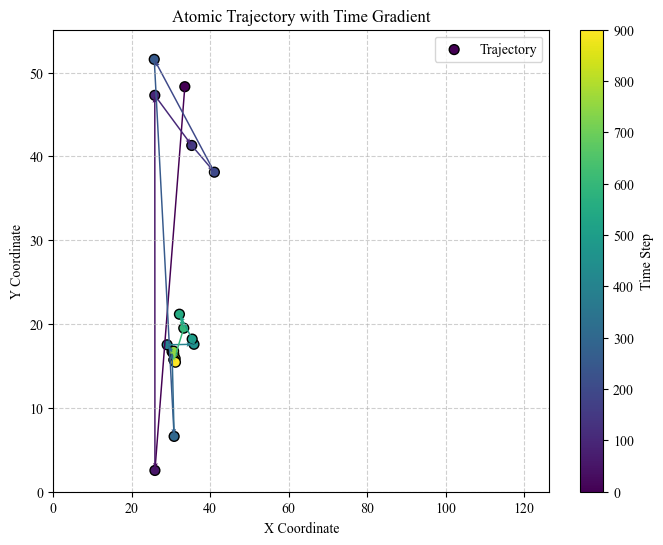

In [289]:
# 单个原子的信息
index = 2
single_atom_xy = [[i[index].x,i[index].y] for i in atom_coords]

# Example data
atom_xy = single_atom_xy
time_list = msd_x_frame
box_size = box_xy

plot_atom_trajectory(atom_xy, time_list, box_size)

In [290]:
import matplotlib.pyplot as plt
import numpy as np

def plot_atom_trajectories(time_series_data, time_list, box_size):
    """
    绘制多个原子的运动轨迹，颜色渐变表示时间。

    :param time_series_data: array, 每一行是一个时间步，每一列是某个原子的 (x, y) 坐标
    :param time_list: list, 每个时间步对应的时间值
    :param box_size: tuple, 盒子大小 (width, height)
    """
    num_atoms = len(time_series_data[0])  # 原子个数
    norm_time = (np.array(time_list) - min(time_list)) / (max(time_list) - min(time_list))  # 归一化时间用于颜色

    fig, ax = plt.subplots(figsize=(8, 5))

    for j in range(num_atoms):  # 遍历所有原子
        atom_coords = np.array([time_series_data[i][j] for i in range(len(time_series_data))])  # 获取原子 j 的轨迹
        x, y = atom_coords[:, 0], atom_coords[:, 1]  # 提取 x, y 坐标
        
        # 画散点，颜色表示时间
        sc = ax.scatter(x, y, c=time_list, cmap="viridis", edgecolors='k', s=20)
        
        # 计算位移矢量
        dx = np.diff(x)
        dy = np.diff(y)

        # 画箭头，颜色表示时间
        ax.quiver(x[:-1], y[:-1], dx, dy, angles='xy', scale_units='xy', scale=1,
                  color=plt.cm.viridis(norm_time[:-1]), width=0.003)

    # 设置盒子边界
    ax.set_xlim(0, box_size[0])
    ax.set_ylim(0, box_size[1])
    ax.set_xlabel("X Coordinate")
    ax.set_ylabel("Y Coordinate")
    ax.set_title("Atomic Trajectories with Time Gradient")

    # 添加颜色条
    cbar = plt.colorbar(sc, ax=ax)
    cbar.set_label("Time Step")

    plt.grid(True, linestyle="--", alpha=0.6)
    #plt.show()

In [291]:
# 多个原子的信息 
msd_frame_start = 0
msd_frame_end = 950
msd_frame_step = 100

msd_x_frame = range(msd_frame_start,msd_frame_end,msd_frame_step)
box_xy = [box_len[0],box_len[1]]
atom_coords = []
for i_frame in All_Atom[msd_frame_start:msd_frame_end:msd_frame_step]:
    temp_atom = []
    for j_index in atom_index:
        temp_atom.append(i_frame[j_index-1])
    atom_coords.append(temp_atom)   
print(atom_coords[-1][-1].print_info())

id:4356, type:Si, x:31.1141, y:15.7514, z:4.688, q:2.4
vx:5.35513, vy:-2.96254, vz:11.6869, fx:-2.18867, fy:-3.74628, fz:4.20819
E_total:-32.9402, E_kinetic:0.253299, E_potential:-33.1935
None


In [292]:
atom_trajectories = np.zeros_like(atom_coords)
for i_num,i_frame in enumerate(atom_coords):
    for j_num,j_atom in enumerate(i_frame):
        atom_trajectories[i_num][j_num] = [j_atom.x,j_atom.y]

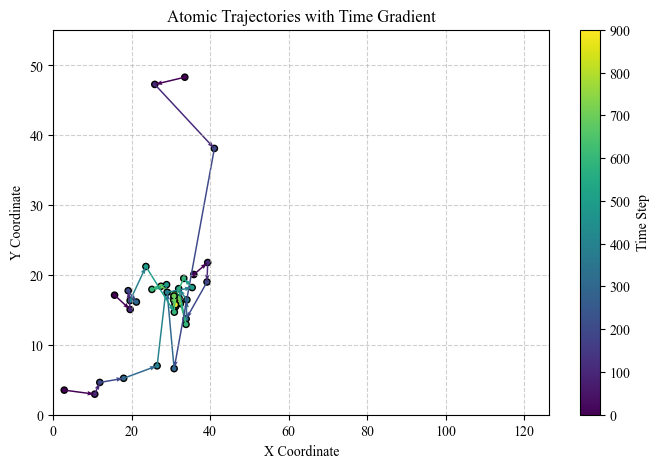

In [293]:
# 示例数据
time_series_data = np.array(atom_trajectories)

time_list = msd_x_frame
box_size = box_xy

plot_atom_trajectories(time_series_data, time_list, box_size)
# draw_q4(draw_knn_q4_list,0.18,cry_point,'Crystal points of LAS (After KNN)')

In [294]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

def plot_msd_bop_q4(list1, list2):
    """
    在同一张图上绘制 q4 分布的散点图，并叠加原子位移轨迹（箭头）。
    
    :param list1: (time_series_data, time_list, box_size) 
        - time_series_data: 每个时间步的原子 (x, y) 坐标
        - time_list: 每个时间步的时间值
        - box_size: 盒子尺寸 (width, height)
    :param list2: (data_temp, critical_q4, label_list, title_name)
        - data_temp: 包含原子坐标和 q4 值的对象列表
        - critical_q4: 阈值
        - label_list: 额外标记的点
        - title_name: 图标题
    """
    time_series_data, time_list, box_size = list1
    data_temp, critical_q4, label_list, title_name = list2

    # 提取 q4 数据
    x_data = [item.x for item in data_temp]
    y_data = [item.y for item in data_temp]
    q4_data = [item.q4 for item in data_temp]

    mean_q4 = sum(q4_data) / len(q4_data)
    num_max_q4 = len([i for i in q4_data if i > critical_q4])
    print(f'Mean q4: {round(mean_q4,4)}, Percentage of Q4 > {critical_q4}: {round(num_max_q4/len(q4_data)*100,2)}%')

    # 颜色映射（Viridis + 橙黄色渐变）
    viridis_cmap = plt.get_cmap('viridis')
    orange_yellow = ['#ffea00', '#ff7f0e']  
    orange_yellow_cmap = LinearSegmentedColormap.from_list('orange_yellow', orange_yellow, N=8)
    colors = np.vstack((viridis_cmap(np.linspace(0, 1, 128)), orange_yellow_cmap(np.linspace(0, 1, 8))))
    custom_cmap = ListedColormap(colors)

    # 创建图像
    fig, ax = plt.subplots(figsize=(10, 6), dpi=80)

    # 1️⃣ 先绘制 q4 的散点分布图
    sc = ax.scatter(x_data, y_data, s=15, c=q4_data, cmap=custom_cmap, marker='o', vmin=0.05, vmax=critical_q4)
    ax.scatter(label_list[0], label_list[1], color='orange', label='Special Points')  # 标记特殊点

    # 2️⃣ 再叠加原子位移轨迹
    num_atoms = len(time_series_data[0])  # 原子个数
    norm_time = (np.array(time_list) - min(time_list)) / (max(time_list) - min(time_list))  # 归一化时间

    for j in range(num_atoms):  # 遍历所有原子
        atom_coords = np.array([time_series_data[i][j] for i in range(len(time_series_data))])  # 获取轨迹
        x, y = atom_coords[:, 0], atom_coords[:, 1]  # 提取 x, y 坐标
        
        # 画散点，颜色表示时间
        ax.scatter(x, y, c=time_list, cmap="viridis", edgecolors='k', s=20)
        
        # 计算位移矢量
        dx = np.diff(x)
        dy = np.diff(y)

        # 画箭头
        ax.quiver(x[:-1], y[:-1], dx, dy, angles='xy', scale_units='xy', scale=1,
                  color=plt.cm.viridis(norm_time[:-1]), width=0.003)

    # 设置盒子边界
    ax.set_xlim(0, box_size[0])
    ax.set_ylim(0, box_size[1])
    ax.set_xlabel("X Coordinate")
    ax.set_ylabel("Y Coordinate")
    ax.set_title(title_name)

    # 添加颜色条
    cbar = plt.colorbar(sc, ax=ax)
    cbar.set_label("q4 Value")

    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()


Mean q4: 0.1677, Percentage of Q4 > 0.18: 49.62%


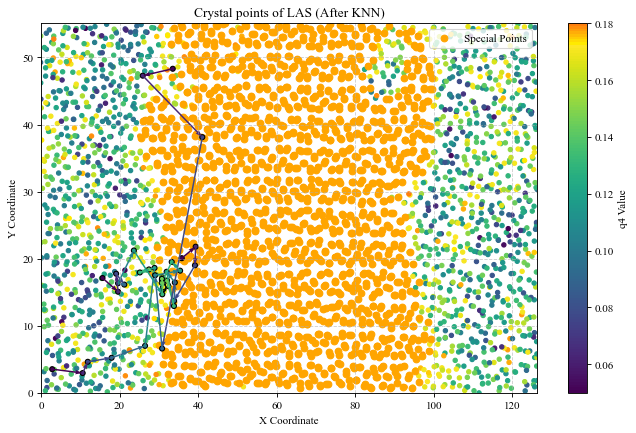

In [295]:
list1 = [time_series_data, time_list, box_size]
list2 = [draw_knn_q4_list,0.18,cry_point,'Crystal points of LAS (After KNN)']
plot_msd_bop_q4(list1, list2)

In [ ]:
# 存储两种list 当前分析的所有帧数 以及得到了的帧数


In [186]:
atom_coords[1]

# 然后分析离晶体不远的近邻信息

In [107]:
# 然后分析性质随距离的变化
# id0, type0, q, x, y, z, vx, vy, vz, fx, fy, fz, c_ke_atom, c_pe_atom, v_e_total

In [109]:
np.linspace(0,5,3)

array([0. , 2.5, 5. ])

In [206]:
import math
# id0, type0, q, x, y, z, vx, vy, vz, fx, fy, fz, c_ke_atom, c_pe_atom, v_e_total
def ana_properties(ana_atom_list, delta,max_range):
    # 切分多少块儿
    count_num = math.ceil(max_range/delta)
    # 其实就是表示一下x的范围 
    data_range = np.arange(0,max_range,delta)
    # 记录数据 sum
    data_list = np.zeros_like(data_range)
    # 记录次数 count
    count_list = np.zeros_like(data_list)
    for i_item in ana_atom_list:
        i_atom,i_q4,i_dis = i_item
        if i_dis<max_range:
            index = math.floor(i_dis/delta)
            data_list[index]+= (i_atom.vx**2+ i_atom.vy**2+ i_atom.vz**2)**0.5
            #data_list[index]+= i_atom.c_ke_atom
            count_list[index]+=1
    for i in range(len(count_list)):
        if count_list[i]==0:
            count_list[i]=1
    res = data_list/count_list
    return [data_range,data_list]

In [208]:
# test_list = filter_list_0 label_atoms_list
test_list = label_atoms_list
def ana_ele(ele_type):
    si_list = []
    for i in test_list:
        if i[0].type == ele_type:
            si_list.append(i)
    print(si_list[0])
    res_si = ana_properties(si_list,0.2,20)
    return res_si[0],res_si[1]


[<__main__.Atom object at 0x000002288621D0D0>, 100, 43.56881262496017]
[<__main__.Atom object at 0x0000022885EE9790>, 100, 32.765341192649835]
[<__main__.Atom object at 0x0000022885EB2540>, 100, 43.69326579148426]


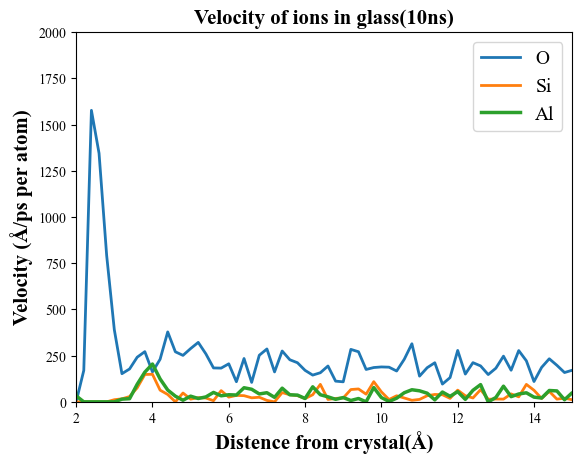

In [216]:
x1,y1 = ana_ele('O')
x2,y2 = ana_ele('Si')
x3,y3 = ana_ele('Al')

# 分别绘制三条线
plt.plot(x1, y1, label='O',linewidth=2.0)  # 绘制氧(O)的线
plt.plot(x2, y2, label='Si',linewidth=2.0) # 绘制硅(Si)的线
plt.plot(x3, y3, label='Al',linewidth=2.5) # 绘制铝(Al)的线

# 添加图例和标签
plt.legend(fontsize=14)
plt.ylim(0,2000)
plt.xlim(2,15)
plt.xlabel('Distence from crystal(Å)', fontsize=15, fontweight='bold')
plt.ylabel('Velocity (Å/ps per atom)', fontsize=15, fontweight='bold')
plt.title('Velocity of ions in glass(10ns)', fontsize=15, fontweight='bold')

# 显示图形
plt.show() 

In [293]:
# 看一下配位数的变化
Si_list = []
Al_list = []
test_list = label_atoms_list.copy()
for i_atom in test_list:
    if i_atom[0].type == 'Si' and i_atom[-1]<20:
        Si_list.append(i_atom)
    if i_atom[0].type =='Al' and i_atom[-1]<20:
        Al_list.append(i_atom)
test_ana_list = Al_list
neibor_list = []
for i_item in test_ana_list:
    i_atom,i_q4,i_dis = i_item
    temp_neibor = []
    for j_item in label_atoms_list:
        j_atom,j_q4,j_dis = j_item
        dis = cal_ppp_dis1(box_len,i_atom,j_atom)
        if dis<2.2:
            temp_neibor.append(j_atom)
    neibor_list.append(temp_neibor)

In [294]:
delta = 0.5
x_list = np.arange(0,20,delta)
data_list = np.zeros_like(x_list)
count_list = np.zeros_like(x_list)
for i_num in range(len(test_ana_list)):
    i_atom,i_q4,i_dis = test_ana_list[i_num]
    if dis>20:
        continue
    index = int(i_dis/delta)
    count = len(neibor_list[i_num])
    count_list[index] = count

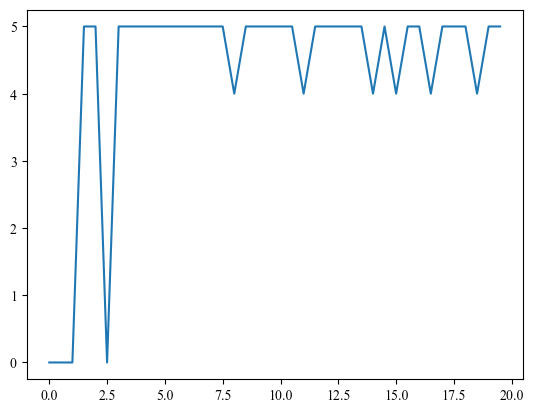

In [295]:
plt.plot(x_list,count_list)

In [245]:
x_list = np.linspace(0,20,201)
print(x_list[:10])

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]


In [281]:
np.arange(0,20,0.5)

array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
        5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5,
       11. , 11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. , 15.5, 16. ,
       16.5, 17. , 17.5, 18. , 18.5, 19. , 19.5])

In [370]:
label_atoms_list[0]

[<__main__.Atom at 0x20f12b37620>, 100, 16.886626947112948]

In [371]:
filter_list_0[0]

NameError: name 'filter_list_0' is not defined

In [ ]:
x,y = ana_ele('O')
plt.plot(x,y)


[<__main__.Atom object at 0x000002020C181790>, 100, 43.2743059944611]


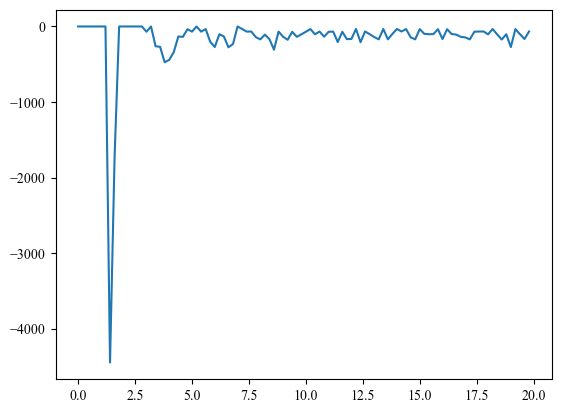

In [198]:
###
x,y = ana_ele('Si')
plt.plot(x,y)

[<__main__.Atom object at 0x000002020C0DED80>, 100, 20.24828276400002]


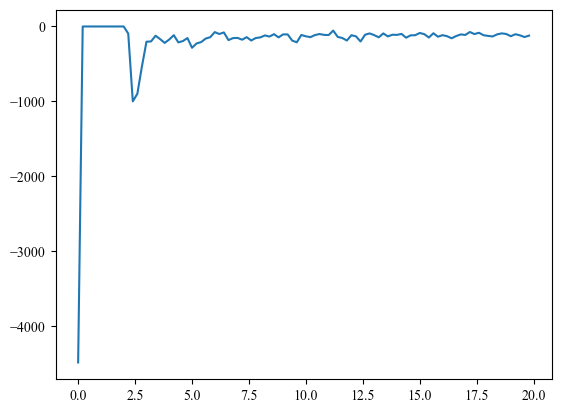

In [200]:
x,y = ana_ele('O')
plt.plot(x,y)


In [222]:
# 设置全局字体为Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'

In [663]:
x1,y1 = ana_ele('O')
x2,y2 = ana_ele('Si')
x3,y3 = ana_ele('Al')

# 分别绘制三条线
plt.plot(x1, y1, label='O',linewidth=2.0)  # 绘制氧(O)的线
plt.plot(x2, y2, label='Si',linewidth=2.0) # 绘制硅(Si)的线
plt.plot(x3, y3, label='Al',linewidth=2.5) # 绘制铝(Al)的线

# 添加图例和标签
plt.legend(fontsize=14)
plt.ylim(-500,50)
plt.xlim(2,20)
plt.xlabel('Distence from crystal(Å)', fontsize=15, fontweight='bold')
plt.ylabel('Energy (eV per atom)', fontsize=15, fontweight='bold')
plt.title('Total energy of ions in glass', fontsize=15, fontweight='bold')

# 显示图形
plt.show()

[<__main__.Atom object at 0x0000020260675970>, 0.12092955150005726, 0.07424115219739173]


IndexError: list index out of range

In [178]:
import math
# id0, type0, q, x, y, z, vx, vy, vz, fx, fy, fz, c_ke_atom, c_pe_atom, v_e_total
def ana_number(ana_atom_list, delta,max_range):
    count_num = math.ceil(max_range/delta)
    data_range = np.arange(0,max_range,delta)
    data_list = np.zeros_like(data_range)
    count_list = np.zeros_like(data_list)
    for i_item in ana_atom_list:
        i_atom,i_q4,i_dis = i_item
        if i_dis<max_range:
            index = math.floor(i_dis/delta)
            # data_list[index]+= np.linalg.norm([i_atom.fx, i_atom.fy, i_atom.fz])
            count_list[index]+=1
    return [data_range,count_list]
def ana_ele_number(ele_type):
    si_list = []
    for i in label_atoms_list:
        if i[0].type == ele_type:
            si_list.append(i)
    print(si_list[0])
    res_si = ana_number(si_list,0.2,20)
    return res_si[0],res_si[1]

[<__main__.Atom object at 0x000002288621D0D0>, 100, 43.56881262496017]


Text(0.5, 1.0, 'Number atoms')

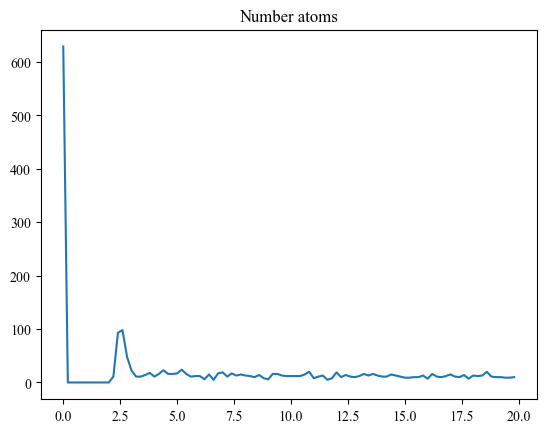

In [180]:
x,y = ana_ele_number('O')
plt.plot(x,y)
plt.title('Number atoms')

In [219]:
# 原子数计算

[<__main__.Atom object at 0x000002288621D0D0>, 100, 43.56881262496017]
[<__main__.Atom object at 0x0000022885EE9790>, 100, 32.765341192649835]
[<__main__.Atom object at 0x0000022885EB2540>, 100, 43.69326579148426]


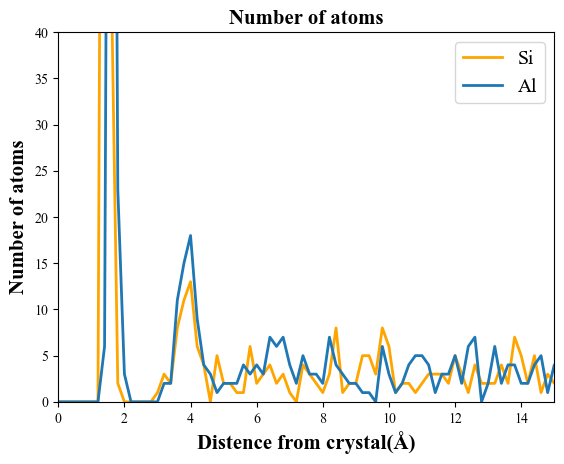

In [204]:
x1,y1 = ana_ele_number('O')
x2,y2 = ana_ele_number('Si')
x3,y3 = ana_ele_number('Al')

# 分别绘制三条线
# plt.plot(x1, y1, label='O',linewidth=2.0)  # 绘制氧(O)的线
plt.plot(x2, y2, label='Si',c='orange',linewidth=2.0) # 绘制硅(Si)的线
plt.plot(x3, y3, label='Al',linewidth=2.0) # 绘制铝(Al)的线

# 添加图例和标签
plt.legend(fontsize=14)
plt.ylim(0,40)
plt.xlim(0,15)
plt.xlabel('Distence from crystal(Å)', fontsize=15, fontweight='bold')
plt.ylabel('Number of atoms', fontsize=15, fontweight='bold')
plt.title('Number of atoms', fontsize=15, fontweight='bold')

# 显示图形
plt.show()

# 然后计算 MSD

(5226, 3)
Mean_q4:0.14863865403037366


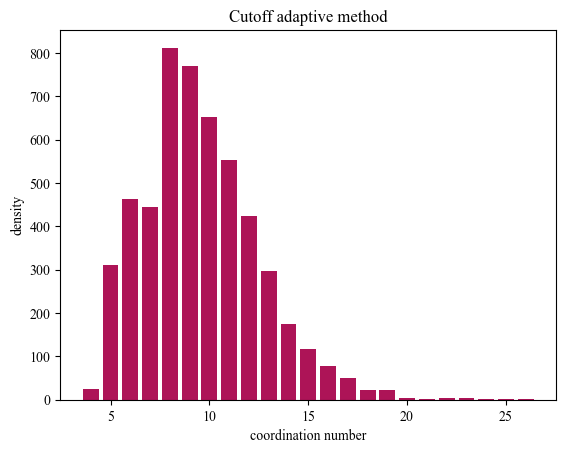

In [382]:
origin_ana_atom_list_0, origin_q4_q6_list_0,box_len_0 = cal_bop(frames,2)

(5226, 3)
Mean_q4:0.14960715902236185


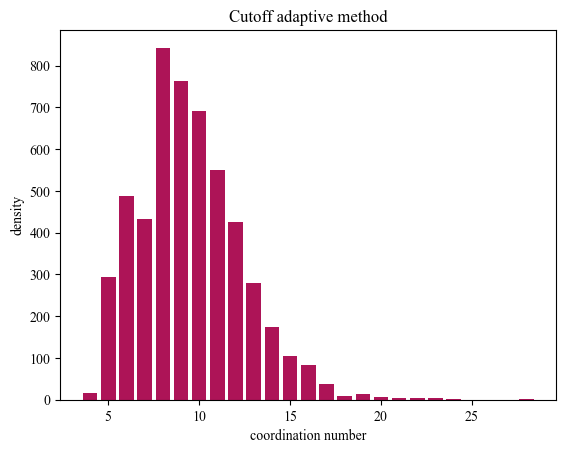

In [383]:
# 得到元素BOP

origin_ana_atom_list_1, origin_q4_q6_list_1,box_len_1 = cal_bop(frames,100)

In [384]:
# 只要 O
draw_element = ['O']
q4_q6_list_0 = origin_q4_q6_list_0.copy()
ana_atom_list_0 = origin_ana_atom_list_0.copy()
results_xyz_q4_q6_0 = select_ele(origin_ana_atom_list_0,draw_element,q4_q6_list_0)
# 
q4_q6_list_1 = origin_q4_q6_list_1.copy()
ana_atom_list_1 = origin_ana_atom_list_1.copy()
results_xyz_q4_q6_1 = select_ele(origin_ana_atom_list_1,draw_element,q4_q6_list_1)
######
# 近邻算法优化BOP
filter_list_0 = filter_bop(results_xyz_q4_q6_0)
filter_list_1 = filter_bop(results_xyz_q4_q6_1)

[<__main__.Atom object at 0x0000020F7A374E30>, 0.12092955150005726, 0.07424115219739173]
[<__main__.Atom object at 0x0000020F12B37620>, 0.14739676717881972, 0.09400733059064009]


In [385]:
filter_list_0[0]

[<__main__.Atom at 0x20f7a374e30>, 0.12092955150005726, 0.07424115219739173]

In [389]:
count = 0
test_list = filter_list_0
for i in test_list:
    if i[1]>0.18:
        count+=1
print(count)
count = 0
test_list = filter_list_1
for i in test_list:
    if i[1]>0.18:
        count+=1
print(count)

476
508


476
See Origin Figure
Mean q4:  0.1348    Percentage of Q4 > 0.18: 13.66%


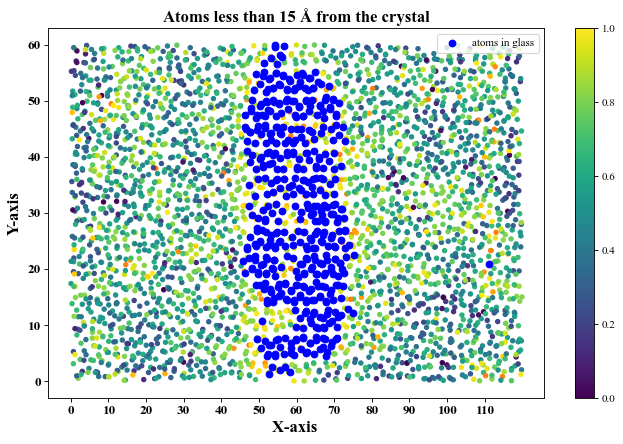

In [401]:
test_temp = filter_list_0
# 先取出所有晶体原子
cry_list = [[],[]]
for i_item in test_temp:
    i_atom,i_q4,i_q6 = i_item
    if i_q4>0.18:
        cry_list[0].append(i_atom.x)
        cry_list[1].append(i_atom.y)
print(len(cry_list[0]))
temp_diff_dis_atom = cry_list
draw_q4(test_temp,0.18,temp_diff_dis_atom)

508
See Origin Figure
Mean q4:  0.1358    Percentage of Q4 > 0.18: 14.58%


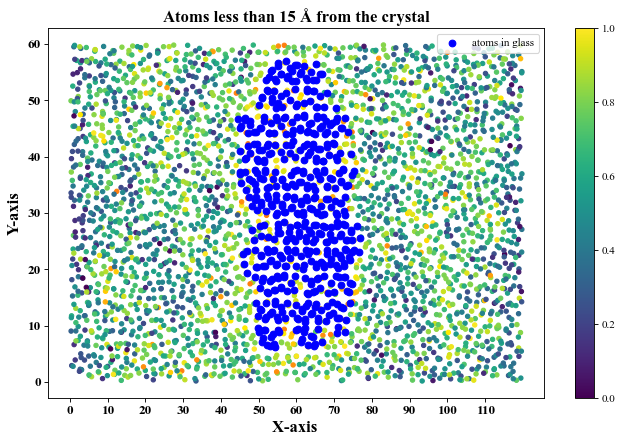

In [399]:
test_temp = filter_list_1
# 先取出所有晶体原子
cry_list = [[],[]]
for i_item in test_temp:
    i_atom,i_q4,i_q6 = i_item
    if i_q4>0.18:
        cry_list[0].append(i_atom.x)
        cry_list[1].append(i_atom.y)
print(len(cry_list[0]))
temp_diff_dis_atom = cry_list
draw_q4(test_temp,0.18,temp_diff_dis_atom)

In [ ]:
# 写入lmp文件

# 绘制 MSD 的函数 

In [635]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.font_manager import FontProperties

def draw(start_xyz,end_xyz,boxsize,list_q4,list_q4_1):

    # 设置全局字体属性
    plt.rcParams['font.weight'] = 'bold'
    plt.rcParams['font.family'] = 'Times New Roman'
    plt.rcParams['font.size'] = 12

    # 设置图像大小
    fig = plt.figure(figsize=(10, 6))

    # 两帧原子的xyz数据，每一帧包含原子的位置信息
    frame1 = np.array(start_xyz)
    frame2 = np.array(end_xyz)

    # 盒子尺寸，假设为 [box_x, box_y, box_z]
    #box_size = [10.0, 10.0, 10.0]

    # 计算位移向量
    displacements = frame2[:, :2] - frame1[:, :2]
    box_size = boxsize
    # 考虑周期性边界条件，根据盒子尺寸修正位移
    for i in range(len(displacements)):
        for dim in range(2):  # 仅考虑 xy 平面
            if displacements[i, dim] > box_size[dim] / 2:
                displacements[i, dim] -= box_size[dim]
            elif displacements[i, dim] < -box_size[dim] / 2:
                displacements[i, dim] += box_size[dim]

    # 计算位移大小
    displacement_magnitude = np.linalg.norm(displacements, axis=1)

    # 计算位移方向
    displacement_direction = displacements / displacement_magnitude[:, np.newaxis]

    # 设置箭头的长度的倍数
    arrow_scale = 2  # 可以根据需要调整箭头的长度

    # 设置颜色映射范围，根据位移大小来映射颜色
    norm = Normalize(vmin=min(displacement_magnitude), vmax=max(displacement_magnitude))

    # 绘制位移图，将位移大小与箭头长度相乘
    plt.quiver(frame1[:, 0], frame1[:, 1], arrow_scale * displacement_direction[:, 0], arrow_scale * displacement_direction[:, 1], 
               arrow_scale * displacement_magnitude, cmap='viridis', angles='xy', scale_units='xy', scale=1, norm=norm)

    # 
    # 设置标题和轴标签的字体和字体大小，以及使用Times New Roman字体
    label_font = FontProperties(family='Times New Roman', style='normal', size=18, weight='bold')


    # 设置图形范围，根据盒子尺寸
    #plt.xlim(0, box_size[0])
    #plt.ylim(0, box_size[1])
    plt.xlabel('X (Å)',fontproperties=label_font)
    plt.ylabel('Y (Å)',fontproperties=label_font)
    # 添加颜色条
    # plt.scatter(list_q4[0],list_q4[1],color='blue',s=30,label='5 ns')
    #plt.scatter(list_q4[0],list_q4[1],color='orange',s=15,label='crystal-like O at 10 ns')
    # title = 'The displacement of '+ ana_element+ ' : '+str(start_frame_num) +' - '+ str(end_frame_num)##+' frame (100ns/1000frames) ' #(60ns/1000frames)
    title = 'MSD of O from 0 ns to 10 ns.'
    plt.title(title, fontproperties=label_font)
    plt.legend()

    # 设置颜色条字体大小、粗细和字体族
    cbar = plt.colorbar(label='Displacement Magnitude')
    cbar.ax.tick_params(labelsize=12, width=2)  # 设置字体大小和粗细
    cbar.ax.yaxis.label.set_font_properties(FontProperties(family='Times New Roman', style='normal', size=12, weight='bold'))

    

    # 显示图形
    plt.show()


In [637]:
start_xyz = []
start_q4 = [[],[]]
###
end_xyz = []
end_q4 = [[],[]]
for i_item in range(len(filter_list_1)):
    i_atom,i_q4 = filter_list_0[i_item][0], filter_list_0[i_item][1]
    j_atom,j_q4 = filter_list_1[i_item][0], filter_list_1[i_item][1]
    i_xyz = [i_atom.x,i_atom.y,i_atom.z]
    j_xyz = [j_atom.x,j_atom.y,j_atom.z]
    start_xyz.append(i_xyz)
    if i_q4>0.18:
        start_q4[0].append(i_atom.x)
        start_q4[1].append(i_atom.y)
    if j_q4>0.18:
        end_q4[0].append(j_atom.x)
        end_q4[1].append(j_atom.y)
    end_xyz.append(j_xyz)

In [639]:
len(end_q4[0])

514

C:\Users\81004\AppData\Local\Temp\ipykernel_8020\3325494677.py:66: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


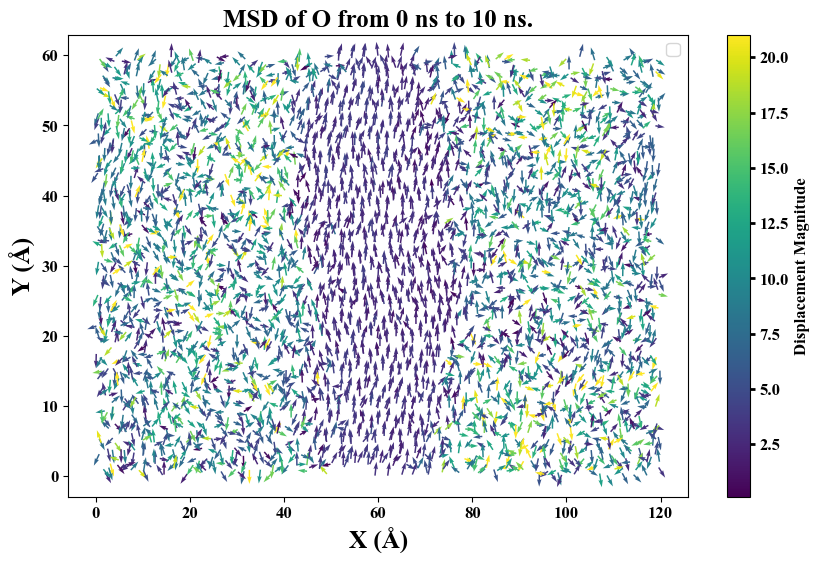

In [641]:
draw(start_xyz,end_xyz,box_len,start_q4,end_q4)

In [228]:
450/600 * 30/0

ZeroDivisionError: float division by zero

# 输出文件

In [6]:
head = 'ITEM: TIMESTEP\n{}\nITEM: NUMBER OF ATOMS\n{}\nITEM: BOX BOUNDS xy xz \
pp pp pp\n0 {}\n0 {} \n0 {}\nITEM: ATOMS id x y z vx vy vz '.format(22,10,22,22,22)
print(head)
row = '{} {} {} {} {} 0 0'.format(0,1, 1,2,1,0.5)
print(row)

ITEM: TIMESTEP
22
ITEM: NUMBER OF ATOMS
10
ITEM: BOX BOUNDS xy xz pp pp pp
0 22
0 22 
0 22
ITEM: ATOMS id x y z vx vy vz 
0 1 1 2 1 0 0


In [7]:
def write_xyz_q4(save_path, result_xyz_q4_q6,i_frame,atom_num):
    # 打开文件以追加内容
    box_x,box_y,box_z = 84.713001, 55.321148, 11.50816
    head = head = 'ITEM: TIMESTEP\n{}\nITEM: NUMBER OF ATOMS\n{}\nITEM: BOX BOUNDS xy xz \
pp pp pp\n0 {}\n0 {} \n0 {}\nITEM: ATOMS id x y z vx vy vz \n'.format(i_frame,atom_num,box_x,box_y,box_z)
    if i_frame==0:
        w_type = 'w'
    else:
        w_type = 'a'
    with open(save_path, w_type) as file:
        # 追加内容
        file.write(head)
        for i in range(len(result_xyz_q4_q6)):
            x,y,z,vx = result_xyz_q4_q6[i][0],result_xyz_q4_q6[i][1],result_xyz_q4_q6[i][2],result_xyz_q4_q6[i][3]
            row = '{} {} {} {} {} 0 0\n'.format(i,x,y,z,vx*100)
            file.write(row)

# 开始多帧计算分析

In [8]:
for i_frame in range(start_frame,end_frame,step_frame):
    data_list = []
    for i in frames[i_frame]['atoms']:
        data_list.append([i['element'],i['x'],i['y'],i['z']])
    result_xyz_q4_q6 = cal_bop(data_list,ana_element,draw_element)
    # 得到结果了 然后把结果存下来
    write_xyz_q4(save_path,result_xyz_q4_q6,i_frame,2292)

D:\python_install\lib\site-packages\pyscal3\atoms.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dict.__setitem__(self, key, np.array(val))
